#### Notes

This file contains the code used for the MNIST simulations.

(This file contains the code for our algorithm and for GDA, for the MNIST dataset.  For our algorithm with acceptance rate 1/5, set the "rate" paramter to "rate = 5".  For GDA, set the "rate" parameter to rate = 1.)



In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import random


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

from keras.optimizers import Adam#, SGD
import sys
sys.path.append("../")
from keras import backend as K

from utils_Picky_grayscale import *       # utils file has the filler code and helper functions

from tqdm.notebook import tqdm
from functools import partial

Using TensorFlow backend.


In [2]:
NOISE_SIZE = 100
IMAGE_SIZE = 784

In [5]:
#set filter = true to include only the digits "0" and "1" in the MNIST dataset
X, y, X_test, y_test = load_data(filter=True, balanced=False)

In [6]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, max_iter=1000).fit(X, y)
clf.score(X_test, y_test)

0.9995271867612293

## Training using GDA

In [8]:
adam_optimizer = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)

In [9]:
take_discriminator_steps_2 = partial(take_discriminator_steps, X_train=X, k=1)
getLoss2 = partial(getLoss, X_train=X)
create_gan2 = partial(create_gan, opt=adam_optimizer)

def create_GAN_player():
    ganPlayer = Players(create_generator(OUTPUT_SIZE=IMAGE_SIZE, opt=adam_optimizer), create_discriminator(INPUT_SIZE=IMAGE_SIZE, opt=adam_optimizer), create_gan2, take_generator_steps, take_discriminator_steps_2, change_network, change_network, perturb_generator)    
    return ganPlayer


In [11]:
def training_gd(create_player_function, create_player_function2, T=3000):
    #Number of iterations      

    # this will create a Players object, with two players
    player = create_player_function()
    player2 = create_player_function2()

    j = 0
    losses, ones = [], []
    player.update_y()    
    
    for j in tqdm(range(1, T+1)):
        
        loss = player.value(getLoss2)            
        losses.append(loss)
        
        # perform one gradient update for the generator and one gradient update for the discriminator (we only use "k=1" discriminator gradient steps for MNIST)
        player.update_x()        
        player.update_y()        
        
        if j%10 == 0:
            noise= np.random.normal(loc=0, scale=1, size=[1000, 100])
            generated_images = player.get_x().predict(noise)
            ones.append(sum(clf.predict(generated_images))/1000)
        
        if j%500 == 0:
            plot_generated_images(0, player.get_x(), save=False, examples=25, dim=(5,5), figsize=(3,3))        

    return player, losses, ones

In [ ]:
reps = 5
ones_gda = []

for _ in range(reps):
    K.clear_session()
    adam_optimizer = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    take_discriminator_steps_2 = partial(take_discriminator_steps, X_train=X, k=1)
    getLoss2 = partial(getLoss, X_train=X)
    create_gan2 = partial(create_gan, opt=adam_optimizer)

    ganPlayerGD, losses, ones = training_gd(create_GAN_player, create_GAN_player, T=10000)
    ones_gda.append(list(ones))

<ErrorbarContainer object of 3 artists>

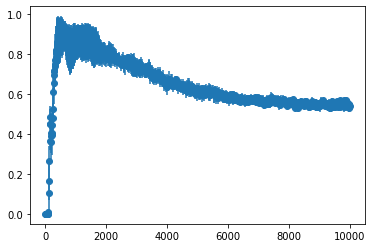

In [91]:
plt.errorbar(np.linspace(0, 10000, 1000), np.mean(ones_gda,axis=0), np.std(ones_gda,axis=0), fmt="o")

## Training using Our Algorithm

In [14]:
def training_gd_mx(create_player_function, create_player_function2, T=3000):
    #Number of iterations

    # this will create a Players object, with two players
    player = create_player_function()
    player2 = create_player_function2()

    j = 0
    
    losses, ones=[], []
    
    old_loss = 100
    player.update_y()

    
    #how often to not accept/reject
    rate = 5
    
    for j in (range(1,T+1)):
        
        loss = player.value(getLoss2)            
        losses.append(loss)
        
        
        #save generator weights and the old loss    

        if j%rate != 0:
            player2.change_x(player.get_x())        
            player2.change_y(player.get_y())
            loss_old = player.value(getLoss2)  
        
        
        # perform one gradient update for the generator and one gradient update for the discriminator (we only use "k=1" discriminator gradient steps for MNIST)
        player.update_x()        
        player.update_y()        
        
        
        #Accept/reject Step
        if j%rate != 0:
            loss_new = player.value(getLoss2)            
        
            if loss_new > loss_old:
                print("Reject")
                player.change_x(player2.get_x())        
                player.change_y(player2.get_y())
            else:
                print("Accept")



        if j%10 == 0:
            noise= np.random.normal(loc=0, scale=1, size=[1000, 100])
            generated_images = player.get_x().predict(noise)
            o = sum(clf.predict(generated_images))/1000
#             print ("--- ONES", o)
            ones.append(o)

        if j%500 == 0:
            plot_generated_images(j, player.get_x(), save=False, examples=25, dim=(5,5), figsize=(3,3))        
        

    return player, losses, ones

In [ ]:
K.clear_session()
reps = 5
ones_mx = []

for _ in tqdm(range(reps)):
    adam_optimizer = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)

    take_discriminator_steps_2 = partial(take_discriminator_steps, X_train=X, k=1)
    getLoss2 = partial(getLoss, X_train=X)
    create_gan2 = partial(create_gan, opt=adam_optimizer)

    def create_GAN_player():
        ganPlayer = Players(create_generator(OUTPUT_SIZE=IMAGE_SIZE, opt=adam_optimizer), create_discriminator(INPUT_SIZE=IMAGE_SIZE, opt=adam_optimizer), create_gan2, take_generator_steps, take_discriminator_steps_2, change_network, change_network, perturb_generator)    
        return ganPlayer

    ganPlayerGD_mx, losses_mx, ones = training_gd_mx(create_GAN_player, create_GAN_player, T=10000)
    ones_mx.append(list(ones))

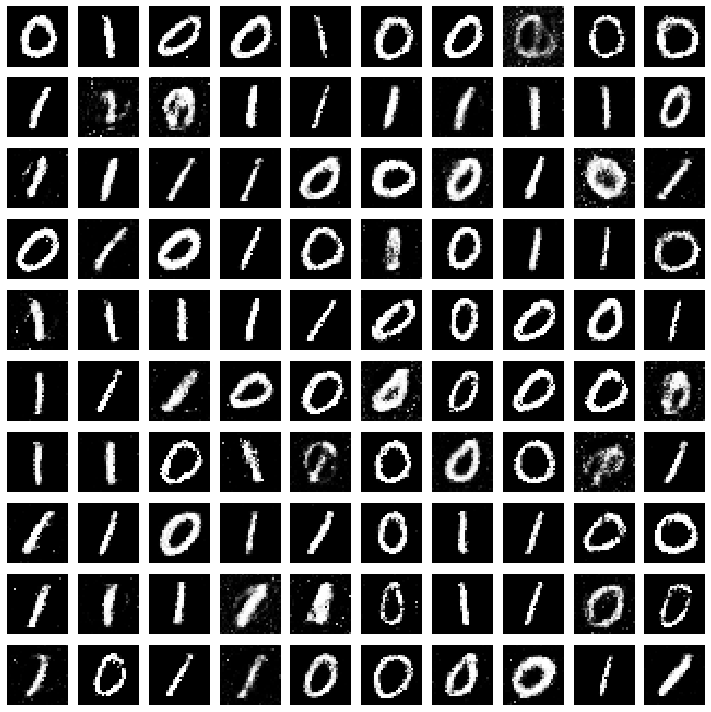

In [17]:
plot_generated_images(0, ganPlayerGD_mx.get_x(), save=False)